# Attempting semantic segmentation with SAM

In [72]:
from torch.utils.data import Dataset
import os
import h5py
import torch
import numpy as np
from datasets import Dataset
from PIL import Image
import random
import matplotlib.pyplot as plt

In [73]:
# Path to the folder containing the .h5 files
path = '/Users/vihaan/Workspace/Local_AI_Earth/Semantic_Segmentation/L4S_Data/TrainData/'

# List of .h5 images
image_directory_path = path + 'img' 

# List of .h5 labels
labels_directory_path = path + 'mask'

# Step 1: Scan through folders to get .h5 files
img_files = [os.path.join(image_directory_path, f) for f in os.listdir(image_directory_path) if f.endswith('.h5')]
mask_files = [os.path.join(labels_directory_path, f) for f in os.listdir(labels_directory_path) if f.endswith('.h5')]
assert len(img_files) == len(mask_files), "Number of images and masks do not match!"

# Step 2 and 3: Open .h5 files, read data, and store in lists
img_list = []
mask_list = []

for img_file, mask_file in zip(img_files, mask_files):
    with h5py.File(img_file, 'r') as file:
        img_list.append(file['img'][:])
    with h5py.File(mask_file, 'r') as file:
        mask_list.append(file['mask'][:])

# Step 4: Convert lists of numpy arrays into single numpy arrays
images = np.array(img_list)
masks = np.array(mask_list)

print(images.shape)  # Should print (number of images, dimensions of image)
print(masks.shape)   # Should print (number of masks, dimensions of mask)


(3799, 128, 128, 14)
(3799, 128, 128)


In [57]:
img = images[1000]
print(img.shape)

rgb = img[:,:,4:1:-1]


(128, 128, 14)


In [55]:
img[:,:,4:1:-1].shape

(128, 128, 3)

In [33]:
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray((img[:,:,4:1:-1] * 255).astype(np.uint8)) for img in images],
    "label": [Image.fromarray(mask) for mask in masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)
     

In [34]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 3799
})

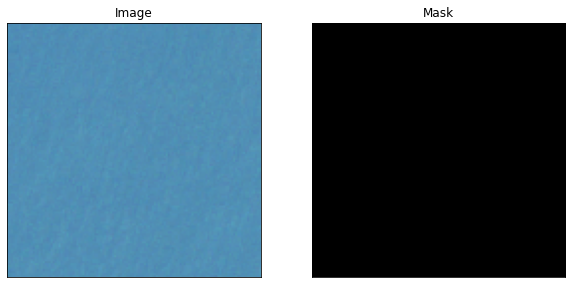

In [59]:

img_num = random.randint(0, images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [60]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [66]:
class SAMDataset(Dataset):
    """
    This class is used to create a dataset that serves input images and masks.
    It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
    """
    def __init__(self, dataset, processor, img_dir, mask_dir):
        self.dataset = dataset
        self.processor = processor
        self.img_files = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.h5')]
        self.mask_files = [os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith('.h5')]
        assert len(self.img_files) == len(self.mask_files), "Number of images and masks do not match!"


    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        with h5py.File(self.img_files[idx], 'r') as file:
            img = torch.tensor(file['img'][:])
        with h5py.File(self.mask_files[idx], 'r') as file:
            mask = torch.tensor(file['mask'][:])
            
        item = self.dataset[idx]
        image = item["image"]
        ground_truth_mask = np.array(item["label"])

        # get bounding box prompt
        prompt = get_bounding_box(ground_truth_mask)

        # prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}

        # add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs
     

In [67]:

# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [68]:


# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor, img_dir=image_directory_path, mask_dir=labels_directory_path)

In [69]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)


pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (128, 128)


In [70]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [71]:

batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)
     

TypeError: list indices must be integers or slices, not list